![CFD.ML v.20](<CFD.ML v2.0.png>)

CFD.ML is delivered via DNV WindFarmer's web API. It is a machine learning model that can predict turbine interaction loss factors, both wake and blockage correction losses together. Find out more in the [WindFarmer documentation](https://myworkspace.dnv.com/download/public/renewables/windfarmer/manuals/latest/CalcRef/TurbineInteractions/CFDML/CFDML.html).

With this notebook you can:
1. import the wind farm data model as a json file, exported from WindFarmer, or converted from Openwind json or other formats.
1. define calculation settings
1. run the calculation and diagnose errors
1. interogate and visualise the results, comparing them to those from traditional engineering models. 

In [1]:
import os
import requests
import json
import time
import random
import asyncio
import math
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np


C:\Users\tolev\AppData\Local\Temp\ipykernel_29472\1345349817.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import the API inputs as a json file
The easiest and most reliable way to web API inputs is via the WindFarmer desktop application. 
Export the annual energy production calculation API input settings from within your workbook using an in-app script. Edit the file path and call:

```Toolbox.ExportWindFarmerEnergyJson( @"C:\folder\my_aep_calculation_inputs.json" );```

If you wish to construct the inputs yourself, see the datamodel described in our [API documentation and OpenAPI specification](https://myworkspace.dnv.com/download/public/renewables/windfarmer/manuals/latest/WebAPI/Introduction/Introduction.html). 

We can also asist with a script to convert the workbook JSON file exported from OpenWind to the WindFarmer format.

In [2]:
# Export AEP input settings from your Windfarmer workbook using an in-app script and calling Toolbox.ExportWindFarmerEnergyJson( input_data_file_path ):
input_json_file_path = r'..\..\..\DemoData\TheBowl\TheBowl.json'
# The json file containing pre-set atmospheric conditions, available to WindFarmer customers
atmospheric_conditions_presets_file_path = r"C:\Repos\CfdmlValidation\atmospheric_presets\preset_atmospheric_conditions.json"

# project Info:
projectInfo = { "projectId": "TheBowl",
                "siteLatitude": 36.5,
                "siteLongitude": -75.1} 

### load the workbook JSON inputs

The project contains 110 turbines accross 1 wind farms


Text(0.5, 1.0, 'TheBowl')

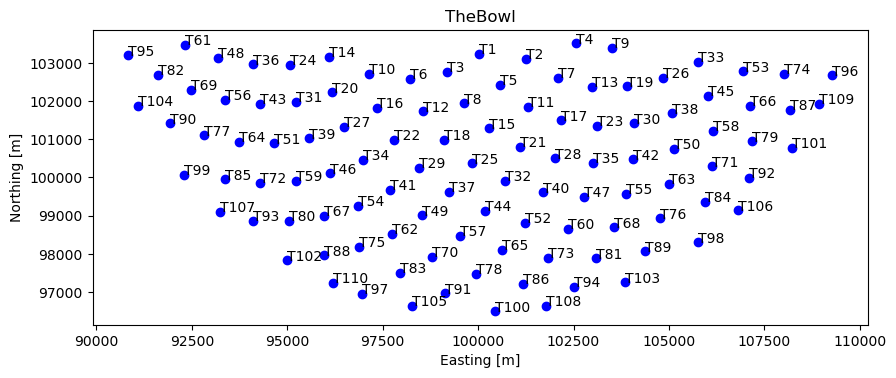

In [3]:
with open(input_json_file_path) as f:
    json_string = f.read()
    json_input = json.loads(json_string)

turbines = []
for farm in json_input["windFarms"]:
    for turbine in farm["turbines"]:
        turbines.append(turbine)
number_of_turbines = len(turbines)
print(f'The project contains {number_of_turbines} turbines accross {len(json_input["windFarms"])} wind farms')

fig1, ax = plt.subplots(figsize=(10,7))
for wt in turbines:
    ax.scatter(wt['location']['easting_m'], wt['location']['northing_m'], c='b')
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Northing [m]")
    ax.set_aspect('equal', adjustable='box')
    ax.annotate(wt['name'],[wt['location']['easting_m'], wt['location']['northing_m']] )
ax.set_title(f'{projectInfo["projectId"]}')

# API setup
To access the API you need a authorization token. 
This should be kept secure - and not added to source control, so I'm getting it from an environment variable. See setup instructions for saving your access key as an environment variable documented [here.](https://myworkspace.dnv.com/download/public/renewables/windfarmer/manuals/latest/WebAPI/Introduction/gettingStarted.html)

In [4]:
api_url = 'https://windfarmer.uat.dnv.com/api/v2/'
auth_token = os.environ['WINDFARMER_UAT_KEY']
#api_url = 'https://windfarmer.dnv.com/api/v2/'
#auth_token = os.environ['WINDFARMER_ACCESS_KEY']
# The token should be passed as an Authorization header. We also need to set the `Content-Type` to let the API know that we're sending JSON data.
headers = {
    'Authorization': f'Bearer {auth_token}',
    'Content-Type': 'application/json'
}

### Call `Status` to check your API connection

In [5]:
response = requests.get(api_url + 'Status', headers = headers)
print(f'Response from Status: {response.status_code}')
if response.status_code == 200:
    text = json.loads(response.text)
    print(f'{text["message"]} You are ready to run calculations!')
    print(f'  WindFarmer API version = {text["windFarmerServicesAPIVersion"]}')
    print(f'  Calculations version = {text["calculationLibraryVersion"]}')
else:
    print(response.text)
    print('Check your access key is saved in the environment variable specified above, and up to date')

Response from Status: 200
Connection to DNV WindFarmer Services API was successful. You are ready to run calculations!
  WindFarmer API version = 2.4.14
  Calculations version = 2.4.30.0


# Choose model inputs 

**Note**: the part responsible for model settings in the input jsons contained in the ```input_json_file_path```  will get overwritten by the settings specified

In [6]:
# specify the desired model combination
WAKE_MODEL_CHOICE = "CFDML" # EddyViscosity/ModifiedPark/TurbOPark/CFDML    # Note CFDML wakes calculates the full TILF (wakes + blockage)
BLOCKAGE_MODEL_CHOICE = "CFDML" # BEET/CFDML                                # Note if you choose CFDML wakes, you can only choose CFD.ML blockage. 
CALCULATE_EFFICIENCIES = True #True/False                                   # Calculating efficiencies gives you a full breakdown of wakes, blockage, neighbour wakes etc. but takes longer to compute
CFDML_VERSION = "2.2.0"
BLOCKAGE_APPLICATION_METHOD = "OnWindSpeed" # OnWindSpeed / OnEnergy
NUMBER_OF_DIRECTION_STEPS = 180

# Note that the large wind farm correction settings are used in the by-wind speed extrapolation of cfd.ml, 
# so set these settings as required for your project.
lwf_paramters = { # LWF's default offshore settings
                    "baseRoughnessZ01": 0.03,
                    "increasedRoughnessZ02": 0.06,
                    "geometricWidthDiameters": 1.0,
                    "recoveryStartDiameters": 120.0,
                    "fiftyPercentRecoveryDiameters": 40.0
                }

## Load and select atmospheric condition pre-sets for your site
You will need to define a stablity rose, defining the proportion of conditions in each class for each direction sector

In [7]:
with open(atmospheric_conditions_presets_file_path, "r") as f:
    atmosperhic_condition_presets = json.load(f)
atmosperhic_condition_presets_df = pd.DataFrame(atmosperhic_condition_presets).T
atmosperhic_condition_presets_df

The training has been performed over a wide range of wind farms and atmospheric conditions as can be seen in the plots below.
| Wind farm parameters | Atmopsheric conditions |
|-|-|
|![alt text](trainingset_metadata.png) |![alt text](trainingset_metadata_atmos.png)|

### Define the proportion of each atmospheric condition class by wind direction
Edit the direction sectors and proportion of data that falls in each atmospheric condition class for each. 

We support custom direction sectors, so no need to specify 12 equal sectors. 

If you do not want to vary the distribution by direction, simply add one bin, 0 to 360 e.g:
```
atmosphericConditionProbabilityDistribution = [{
    "fromDirection_degrees": 0,
    "toDirection_degrees":   360, 
    "atmosphericConditionClassIds": [stable_ID, unstable_ID],
    "probabilityForClasses": [0.6, 0.4]
}
]
```

In [8]:
# selected atmospheric condition pre-sets to use in simulation: 
stable_ID = "onshore-stable"
unstable_ID = "onshore-unstable"

atmosphericConditionProbabilityDistribution = [{
    "fromDirection_degrees": 345,
    "toDirection_degrees":   115, 
    "atmosphericConditionClassIds": [stable_ID, unstable_ID],
    "probabilityForClasses": [0.6, 0.4]
},
{
    "fromDirection_degrees": 115,  
    "toDirection_degrees": 285, 
    "atmosphericConditionClassIds": [stable_ID, unstable_ID],
    "probabilityForClasses": [0.45, 0.55]
},
{
    "fromDirection_degrees": 285,
    "toDirection_degrees"  : 345,
    "atmosphericConditionClassIds": [stable_ID, unstable_ID],
    "probabilityForClasses": [0.5, 0.5]
},
]


Distinct atmospheric conditions classes to simulate:
 ['onshore-stable', 'onshore-unstable']


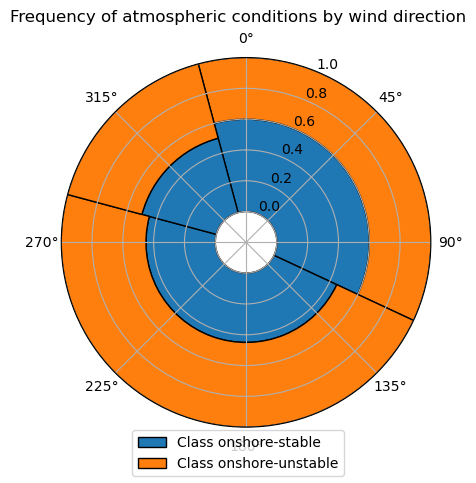

In [9]:
# Plot the frequency distribution of atmospheric conditions
all_atmos_classes = []
for sector in atmosphericConditionProbabilityDistribution:
    for class_id in sector["atmosphericConditionClassIds"]:
        if class_id not in all_atmos_classes:
            all_atmos_classes.append(class_id)
print(f'Distinct atmospheric conditions classes to simulate:\n {all_atmos_classes}')

def average_angles(angles_in_radians):
    #Calculate the sum of sine and cosine components
    sin_sum = sum(math.sin(angle) for angle in angles_in_radians)
    cos_sum = sum(math.cos(angle) for angle in angles_in_radians)
    
    # Calculate the average angle in radians
    result = math.atan2(sin_sum, cos_sum)
    # ensure within 0-2pi
    if result < 0:
        result = 2*math.pi +result
    elif result > 2*math.pi:
        result = result - 2*math.pi
    return result

def angle_difference(to_angle_in_radians, from_angle_in_radians):
    if to_angle_in_radians < from_angle_in_radians:
        from_angle_in_radians = from_angle_in_radians - 2*math.pi
    angle_difference = to_angle_in_radians - from_angle_in_radians
    return  angle_difference 


temp = pd.DataFrame(atmosphericConditionProbabilityDistribution)
df_for_stability_rose_plot = pd.DataFrame()
for i in range(0,2):
    temp2 = temp.copy()
    temp2['atmosphericConditionClassIds'] = temp2['atmosphericConditionClassIds'].apply(lambda x: x[i])
    temp2['probabilityForClasses'] = temp2['probabilityForClasses'].apply(lambda x: x[i])
    df_for_stability_rose_plot = pd.concat([df_for_stability_rose_plot, temp2], axis=0)
df_for_stability_rose_plot['angular_bin_center'] = pd.Series([average_angles([math.radians(x["toDirection_degrees"]), math.radians(x["fromDirection_degrees"])]) for x in atmosphericConditionProbabilityDistribution])#  pd.Series([50, 200, 315, 40, 130, 315])
df_for_stability_rose_plot['angular_bin_center_degrees'] = df_for_stability_rose_plot['angular_bin_center'].map(lambda x: math.degrees(x))
df_for_stability_rose_plot['angular_bin_width'] = pd.Series([angle_difference(math.radians(x["toDirection_degrees"]),math.radians(x["fromDirection_degrees"])) for x in atmosphericConditionProbabilityDistribution])#  pd.Series([50, 200, 315, 40, 130, 315])
df_for_stability_rose_plot['angular_bin_width_degrees'] = df_for_stability_rose_plot['angular_bin_width'].map(lambda x: math.degrees(x))
df_for_stability_rose_plot['cumulative_probability'] = df_for_stability_rose_plot.groupby('angular_bin_center')['probabilityForClasses'].cumsum()

df_for_stability_rose_plot

fig, ax = plt.subplots(subplot_kw={'projection':'polar','theta_offset': np.pi / 2, 'theta_direction': -1})
for key in all_atmos_classes:
    group = df_for_stability_rose_plot[df_for_stability_rose_plot['atmosphericConditionClassIds']==key]
    ax.bar(group['angular_bin_center'], group['probabilityForClasses'], bottom=group['cumulative_probability']-group['probabilityForClasses'],  width=group['angular_bin_width'], label=f'Class {key}', edgecolor='black')
ax.set_ylim([-0.2, 1.0])
fig.suptitle("Frequency of atmospheric conditions by wind direction")
fig.legend(loc='lower center')

In [10]:
# the below dictionaries contain various settings, of which we make a selection for the particular run  (inside set_model_settings)
wake_models = {"EddyViscosity": {"model_key":"eddyViscosity", "model_settings":{"useLargeWindFarmModel": True, "largeWindFarmCorrectionParameters": lwf_paramters}},
               "ModifiedPark":  {"model_key":"modifiedPark", "model_settings": {"useLargeWindFarmModel": True, "largeWindFarmCorrectionParameters": lwf_paramters}},
               "TurbOPark": {"model_key":"turbOPark", "model_settings": {"wakeExpansion": 0.04}},
               "CFDML": {"model_key":"cfdml", "model_settings":{"gnnType": "Offshore", "gnnVersion": CFDML_VERSION, "extrapolationModel":"EddyViscosity"}}}
blockage_models = {"BEET": {"model_key":"beet", "model_settings":{"significantAtmosphericStability": False,
                                                                  "inclusionOfNeighborsBufferZoneInMeters": 1000.0,
                                                                  "blockageCorrectionApplicationMethod": BLOCKAGE_APPLICATION_METHOD }},
                   "CFDML": {"model_key":"cfdml", "model_settings":{"cfdmlSettings": {"gnnType": "Offshore", "gnnVersion": CFDML_VERSION}, 
                                                                    "blockageCorrectionApplicationMethod": BLOCKAGE_APPLICATION_METHOD,
                                                                    "cfdmlBlockageWindSpeedDependency": "FromBlockageExtrapolationCurve"}}}

In [11]:
# the below functions help setup inputs specific to running cfd.ml
def switch_off_fpm_export(input_json):
    # this function makes sure fpm export is switched off - to speed up API response time
    for fpm in input_json["energyEfficienciesSettings"]["turbineFlowAndPerformanceMatrixOutputSettings"].keys():
        if fpm != "localTurbineWindSpeedsOutputSettings":
            input_json["energyEfficienciesSettings"]["turbineFlowAndPerformanceMatrixOutputSettings"][fpm] = False
        else:
            input_json["energyEfficienciesSettings"]["turbineFlowAndPerformanceMatrixOutputSettings"][fpm] = None

def configure_fpm_export(input_json):
    input_json["energyEfficienciesSettings"]["turbineFlowAndPerformanceMatrixOutputSettings"]["outputAmbientWindSpeed"] = True
    input_json["energyEfficienciesSettings"]["turbineFlowAndPerformanceMatrixOutputSettings"]["outputWakedWindSpeed"] = True
    #input_json["energyEfficienciesSettings"]["turbineFlowAndPerformanceMatrixOutputSettings"]["outputPowerOutput"] = True

def set_model_settings(input_json):
    # let's set the modeling options contained in the json
    input_json["energyEfficienciesSettings"]["calculateEfficiencies"] = CALCULATE_EFFICIENCIES
    json_input["energyEfficienciesSettings"]["includeHysteresisEffect"] = False
    json_input["energyEfficienciesSettings"]["includeTurbineManagement"] = False
    json_input["energyEfficienciesSettings"]["calculateIdealYield"] = False

    json_input['energyEfficienciesSettings']['numberOfDirectionSectorsForWakeCalculation'] = NUMBER_OF_DIRECTION_STEPS
    # pull the relevant default settings from the dicts predefined above
    input_json["energyEfficienciesSettings"]["wakeModel"]["wakeModelType"] = WAKE_MODEL_CHOICE
    input_json["energyEfficienciesSettings"]["wakeModel"][wake_models[WAKE_MODEL_CHOICE]["model_key"]] = wake_models[WAKE_MODEL_CHOICE]["model_settings"]
    if WAKE_MODEL_CHOICE == "CFDML":
        extrapolation_model = wake_models["CFDML"]["model_settings"]["extrapolationModel"]
        if extrapolation_model != "BasicFlat":
            input_json["energyEfficienciesSettings"]["wakeModel"][wake_models[extrapolation_model]["model_key"]] = wake_models[extrapolation_model]["model_settings"]
    input_json["energyEfficienciesSettings"]["blockageModel"]["blockageModelType"] = BLOCKAGE_MODEL_CHOICE
    input_json["energyEfficienciesSettings"]["blockageModel"][blockage_models[BLOCKAGE_MODEL_CHOICE]["model_key"]] = blockage_models[BLOCKAGE_MODEL_CHOICE]["model_settings"]

def get_avg_hub_and_tip_heights_for_subject_windfarms(input_json):
    hub_heights = []
    tip_heights = []
    turbine_model_heights = {}
    for turbine_model in input_json["turbineModels"]:
        turbine_model_heights[turbine_model["id"]] = {
            "hub_height": turbine_model["hubHeight_m"],
            "tip_height": turbine_model["hubHeight_m"] + turbine_model["rotorDiameter_m"] / 2.0,
        }

    for subject_wind_farm in input_json["windFarms"]: 
        if subject_wind_farm["isNeighbor"] == False:
            for turbine in subject_wind_farm["turbines"]:
                id = turbine["turbineModelId"]
                hub_heights.append(turbine_model_heights[id]["hub_height"])
                tip_heights.append(turbine_model_heights[id]["tip_height"])
    avg_tip_heights = np.average(tip_heights)
    avg_hub_heights = np.average(hub_heights)
    return avg_hub_heights, avg_tip_heights


def interpolate_profile_at_height( z, zs, profile_values):
    ## we may want something better than linear interpolation?
    # cubicspline_interpolator = scipy.interpolate.CubicSpline(zs, profile_values)
    # value_at_z = cubicspline_interpolator(standard_zs)
    value_at_z = np.interp(z, zs, profile_values)
    return value_at_z


def construct_atmospheric_conditions(atmosphericConditionProbabilityDistribution, atmosperhic_condition_presets, hub_height, tip_height):
    # constructing the whole atmospheric conditions object
    selected_preset_classes = []
    for bin in atmosphericConditionProbabilityDistribution:
        selected_preset_classes.extend(bin["atmosphericConditionClassIds"])
    selected_preset_classes = list(set(selected_preset_classes))
    
    atmosphericConditionClasses = []
    for preset in selected_preset_classes:
        atmosphericConditionClass = {} 
        atmosphericConditionClass["id"] = preset
        
        parameters = {}
        # read tip and hub height data from profiles
        zs = atmosperhic_condition_presets[preset]["z"]
        dvdzs = atmosperhic_condition_presets[preset]["dvdz"]
        tis = atmosperhic_condition_presets[preset]["ti"]
        parameters["turbulenceIntensityAtHubHeight"] = interpolate_profile_at_height(hub_height, zs, tis)
        parameters["turbulenceIntensityAtTipHeight"] = interpolate_profile_at_height(tip_height, zs, tis)
        parameters["windSpeedVerticalGradientHubHeight_per_m"] = interpolate_profile_at_height(hub_height, zs, dvdzs)
        parameters["windSpeedVerticalGradientTipHeight_per_m"] = interpolate_profile_at_height(tip_height, zs, dvdzs)
        parameters["boundaryLayerHeight_m"] = atmosperhic_condition_presets[preset]["boundaryLayerHeight_m"]
        parameters["lapseRate_K_per_100m"] = atmosperhic_condition_presets[preset]["lapseRate_K_per_100m"]
        parameters["deltaThetaAcrossInversionLayer_K"] = atmosperhic_condition_presets[preset]["deltaThetaAcrossInversionLayer_K"]
        parameters["heightInversionLayer_m"] = atmosperhic_condition_presets[preset]["heightInversionLayer_m"]

        atmosphericConditionClass["parameters"] = parameters
        atmosphericConditionClasses.append(atmosphericConditionClass)

    atmosphericConditions = {
        "atmosphericConditionClasses": atmosphericConditionClasses,
        "atmosphericConditionProbabilityDistribution": atmosphericConditionProbabilityDistribution
    }
    return atmosphericConditions


def set_model_settings_for_blockage_only_runs(input_json):
    # turn off wake models etc. so only considering blockage for speed of computation of AEP calculation
    input_json['energyEfficienciesSettings']['wakeModel']['wakeModelType'] = 'NoWakeModel'
    input_json["energyEfficienciesSettings"]["wakeModel"]["noWakeModel"]["useLargeWindFarmModel"] = False
    input_json["energyEfficienciesSettings"]["calculateEfficiencies"] = False
    input_json["energyEfficienciesSettings"]["includeHysteresisEffect"] = False
    input_json["energyEfficienciesSettings"]["includeTurbineManagement"] = False
    input_json["energyEfficienciesSettings"]["calculateIdealYield"] = False
    switch_off_fpm_export(input_json)


In [12]:
# Defining the model inputs
set_model_settings(json_input)
switch_off_fpm_export(json_input)
configure_fpm_export(json_input) # activate wind speed fpms for the flow case visualisations

hub_height, tip_height = get_avg_hub_and_tip_heights_for_subject_windfarms(json_input)
json_input["atmosphericConditions"] = construct_atmospheric_conditions(atmosphericConditionProbabilityDistribution, atmosperhic_condition_presets, hub_height, tip_height)
json_input["projectInfo"] = projectInfo


In [13]:
# write inputs to file
inputs_file_name = f'cfdmlv2apiinputs_{projectInfo["projectId"]}.json' 
with open(inputs_file_name, 'w') as f:
    json.dump(json_input, f, indent=4, allow_nan=False)

### Call `AnnualEnergyProduction` endpoint to calculate results

Define settings required to make a fast evaluation of CFD.ML and BEET blockage correction efficiencies

Some methods to make a calls to the WFer Services API and compute the blockage correction regardless of approach.
We call the asynchronous AEP method for farms with > 150 turbines

In [ ]:
# functions for calling the API

# Polling for status for AnnualEnergyProductionAsync calculations
async def get_jobstatus( job_id: str) -> (str, str):
    params = {}
    params["jobId"] = job_id
    result =  requests.get(api_url + 'AnnualEnergyProductionAsync', headers=headers, params= params)
    result_json = json.loads(result.content)
    return (result_json['status'], result_json['results'] if 'results' in result_json else None)

async def poll_for_status( job_id: str, min_polling_interval_seconds = 20, start_time = None) -> (str, str):
        if start_time == None:
            start_time = time.time()
        status = "PENDING"
        await ( asyncio.sleep(random.random() + 5))
        while(status == 'PENDING' or status == 'RUNNING'):
            (status, results ) = await get_jobstatus( job_id)
            print(f'...Calculation status @ {time.time() - start_time:.2f}s: {status}')
            await ( asyncio.sleep(random.random() + min_polling_interval_seconds))
        return status, results


# Aynchronous calculations are slower, but reliable for long running calculations as we implement a job queue.
async def call_aep_api_async(api_url, headers, input_data, min_polling_interval_seconds):
    start = time.time()
    job_id_response = requests.post(
        api_url + 'AnnualEnergyProductionAsync', 
        headers=headers,
        json = input_data)    
    print(f'Response {job_id_response.status_code} - {job_id_response.reason} in {time.time() - start:.2f}s')
    # Print the error detail if we haven't receieved a 200 OK response
    if job_id_response.status_code != 202:
        print(json.loads(job_id_response.content)['detail'])
    else:
        job_ID = json.loads (job_id_response.text)["jobId"]
        print ('...Job sumbimitted with ID: ')
        print (job_ID)
        status, results = await poll_for_status(job_ID, min_polling_interval_seconds )
        if status == 'FAILED':
            print('Calculation failed, attempting to get some more error detail by calling the synchronous end point')
            call_aep_api_sync(input_data)
            raise Exception("Calculation failed")
        print(f'{status} in {time.time() - start:.2f}s')
        return results


# Synchronous calculations are faster, but unreliable for large wind farms:
def call_aep_api_sync(api_url, headers, input_data):
    start = time.time()
    response = requests.post(
        api_url + 'AnnualEnergyProduction', 
        headers=headers,
        json = input_data)
    print(f'Response {response.status_code} - {response.reason} in {time.time() - start:.2f}s')

    if response.status_code == 200:
        results = json.loads(response.content)
        return results
    else:
        # Print the error detail if we haven't receieved a 200 OK response 
        content = json.loads(response.content)
        print(content["title"])
        print(content)
        errors = content["errors"]
        if errors != None:
            for key in errors:
                print(f'Error:\t{key}:\t{errors[key]}')
        return None
    

# Decide whether to call the synchronous or asynchronous end point based on number of turbines
async def call_aep_api(api_url, headers, input_data):
    turbines = []
    for farm in input_data["windFarms"]:
        for turbine in farm["turbines"]:
            turbines.append(turbine)
    number_of_turbines = len(turbines)
    
    if number_of_turbines < 100:
        print(f'Calling synchronous AEP API')
        results = call_aep_api_sync(api_url, headers, input_data)
    else:
        print(f'Calling asynchronous AEP API')
        time_per_turbine = 1200 / 1000
        min_polling_interval_seconds = number_of_turbines * time_per_turbine / 5
        results = await call_aep_api_async(api_url, headers, input_data, min_polling_interval_seconds)
    return results


In [15]:
# reload inputs from file
with open(inputs_file_name, 'r') as f:
    json_input = json.load(f)

In [16]:
# Make the API call, 
api_response = await call_aep_api( api_url, headers, json_input)

Calling asynchronous AEP API
Response 202 - Accepted in 2.67s
...Job sumbimitted with ID: 
933284e5-59e9-4043-80ae-b6ef0a19f775
...Calculation status @ 8.19s: PENDING
...Calculation status @ 35.98s: PENDING
...Calculation status @ 63.77s: PENDING
...Calculation status @ 91.02s: PENDING
...Calculation status @ 119.01s: PENDING
...Calculation status @ 146.30s: PENDING
...Calculation status @ 174.01s: PENDING
...Calculation status @ 201.49s: PENDING
...Calculation status @ 228.66s: PENDING
...Calculation status @ 256.35s: PENDING
...Calculation status @ 283.60s: PENDING
...Calculation status @ 311.40s: PENDING
...Calculation status @ 342.58s: SUCCESS
SUCCESS in 371.95s


In [17]:
# If want to try getting results after interupting the script, 
# you can uncomment the below, enter your job ID printed above, then try and get the results

# job_id = "772b948e-f31e-49aa-9684-c3ab26d43e85"
# status, api_response = await poll_for_status(job_id)

In [18]:
# write results to file
results_file_name = f'cfdmlv2api_results_{projectInfo["projectId"]}.json' 
with open(results_file_name, 'w') as f:
    f.write(json.dumps(api_response, indent=4))

time.sleep(1)

# Review results
### Report Gross + Full AEP + Wake + Blockage loss factors

Read results back in from file (in case you wish to run plotting and reporting again without recalculation )

In [19]:
with open(results_file_name, 'r') as f:
    results = json.load(f)

In [20]:
# functions for reviewing results
def get_hysteresis_efficiency(results_dict):
    hysteresisAdjustmentOnAnnualEnergyYield_MWh_per_year = sum([float(x['hysteresisAdjustmentOnAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
    internalWakesOnAnnualEnergyYield_MWh_per_year = sum([float(x['internalWakesOnAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
    return hysteresisAdjustmentOnAnnualEnergyYield_MWh_per_year / internalWakesOnAnnualEnergyYield_MWh_per_year

def get_external_wake_efficiency(results_dict):
    largeWindFarmCorrectionOnAnnualEnergyYield_MWh_per_year = sum([float(x['largeWindFarmCorrectionOnAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
    neighborsWakesOnAnnualEnergyYield_MWh_per_year = sum([float(x['neighborsWakesOnAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
    return neighborsWakesOnAnnualEnergyYield_MWh_per_year / largeWindFarmCorrectionOnAnnualEnergyYield_MWh_per_year

def get_internal_wake_efficiency(results_dict):
    internalWakesOnAnnualEnergyYield_MWh_per_year = sum([float(x['internalWakesOnAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
    blockageOnAnnualEnergyYield_MWh_per_year = sum([float(x['blockageOnAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
    return internalWakesOnAnnualEnergyYield_MWh_per_year / blockageOnAnnualEnergyYield_MWh_per_year

def get_blockage_efficiency(results_dict, blockage_correction_application_method):
    blockage_correction_efficiency = -1
    if blockage_correction_application_method == "OnEnergy":
        blockage_correction_efficiency = float(results_dict['weightedBlockageEfficiency'])
    elif blockage_correction_application_method == "OnWindSpeed":
        if CALCULATE_EFFICIENCIES == False:
            print("You must set CALCULATE_EFFICIENCIES = True to compute blockage corrections OnWindSpeed")
        else:
            blockage_on_aep_MWh_per_year = sum([float(x['blockageOnAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
            gross_aep_MWh_per_year = sum([float(x['grossAnnualEnergyYield_MWh_per_year']) for x in results_dict['windFarmAepOutputs']])
            blockage_correction_efficiency = blockage_on_aep_MWh_per_year / gross_aep_MWh_per_year
    else:
        print("blockage_correction_application_method not recognised")
    return blockage_correction_efficiency    

Headline results

In [34]:
# Print results:
print(f'Wake model type = {WAKE_MODEL_CHOICE}')
print(f'Blockage model type = {BLOCKAGE_MODEL_CHOICE}')
print(f'Blockage correction application method = {BLOCKAGE_APPLICATION_METHOD}')

wind_farm_names = str.join(", ", [x['windFarmName'] for x in results['windFarmAepOutputs']])

# summing yields over all subject farms:
full_yield = sum([float(x['fullAnnualEnergyYield_MWh_per_year']) for x in results['windFarmAepOutputs']]) / 1e3
gross_yield = sum([float(x['grossAnnualEnergyYield_MWh_per_year']) for x in results['windFarmAepOutputs']]) / 1e3
total_losses = full_yield / gross_yield
blockage_eff = get_blockage_efficiency(results, BLOCKAGE_APPLICATION_METHOD)

# make a dataframe for reporting
case_summary = pd.DataFrame()
case_summary.index = [wind_farm_names]
case_summary["Gross Yield [GWh/Annum]"] = [gross_yield]
if CALCULATE_EFFICIENCIES:
    internal_wake_eff = get_internal_wake_efficiency(results)
    external_wake_eff = get_external_wake_efficiency(results)
    total_turbine_interaction_efficiency = blockage_eff * internal_wake_eff * external_wake_eff
    case_summary["Blockage efficiency [%]"] = [blockage_eff * 100]
    case_summary["Internal wake efficiency [%]"] = [internal_wake_eff * 100]
    case_summary["External wake efficiency [%]"] = [external_wake_eff * 100]
    case_summary["Total turbine interaction efficiency [%]"] = [total_turbine_interaction_efficiency * 100]
    case_summary["Total modelled losses [%]"] = [total_losses *100]
else: 
    case_summary["Blockage efficiency [%]"] = [get_blockage_efficiency(results, BLOCKAGE_APPLICATION_METHOD) * 100]
    case_summary["Total modelled losses [%]"] = [total_losses *100]
case_summary["Full Yield [GWh/Annum]"] = [full_yield]

case_summary.T.round(1)

Wake model type = CFDML
Blockage model type = CFDML
Blockage correction application method = OnWindSpeed


,Farm
Gross Yield [GWh/Annum],1612.1
Blockage efficiency [%],96.8
Internal wake efficiency [%],89.7
External wake efficiency [%],100.0
Total turbine interaction efficiency [%],86.8
Total modelled losses [%],86.8
Full Yield [GWh/Annum],1399.7


Note:
* Total turbine interaction efficiency = blockage * internal_wake * external_wake
* The total losses can also include hysteresis and curtailment efficiencies, depending on the chosen calculation settings

## Pattern of production
The annual energy production pattern accross the farm

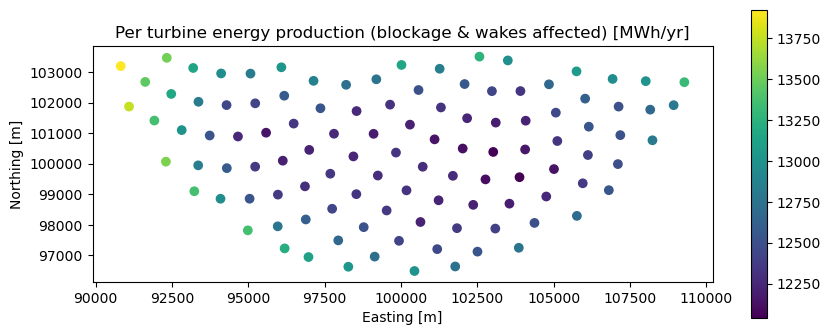

In [ ]:
# Pattern of production - Full yield
per_turbine_results = pd.DataFrame.from_dict(results['windFarmAepOutputs'][0]['turbineResults'])
per_turbine_results.set_index('turbineName', drop=True, inplace=True)
per_turbine_results['easting'] = per_turbine_results['turbineLocation'].map(lambda x: dict(x)['easting_m'])
per_turbine_results['northing'] = per_turbine_results['turbineLocation'].map(lambda x: dict(x)['northing_m'])
fig, ax = plt.subplots(figsize=(10,4))
im = ax.scatter(per_turbine_results['easting'], per_turbine_results['northing'], c=per_turbine_results['fullAnnualYield_MWh_per_year'], cmap='viridis')
ax.set_title("Per turbine energy production (blockage & wakes affected) [MWh/yr]")
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
ax.set_aspect('equal', adjustable='box')
fig.colorbar(im)

## TILF pattern for selected wind directions

In [ ]:
# Select the wind direction and wind speed flow case you wish to review:
wind_direction = 0
wind_speed = 8.0

In [ ]:
def get_atmos_classes_for_direction (wind_direction, atmosphericConditionProbabilityDistribution):
    for sector in atmosphericConditionProbabilityDistribution:
        to_direction = sector["toDirection_degrees"]
        from_direction = sector["fromDirection_degrees"]
        if  from_direction > to_direction :
            to_direction = to_direction + 360.0
            test_wind_direction = wind_direction + 360.0
        if (from_direction <= test_wind_direction and to_direction > wind_direction):
            classes_for_direction = sector["atmosphericConditionClassIds"]
            print(f"atmospheric conditions {classes_for_direction} found for wind direction {wind_direction}")
            return classes_for_direction
    print ("No atmospheric conditions found for wind direction!")
    return None

atmos_classes_for_direction = get_atmos_classes_for_direction(wind_direction, atmosphericConditionProbabilityDistribution)

atmospheric conditions ['onshore-stable', 'onshore-unstable'] found for wind direction 0


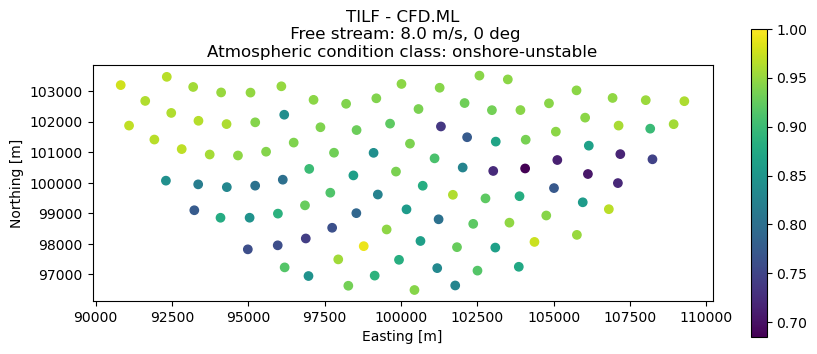

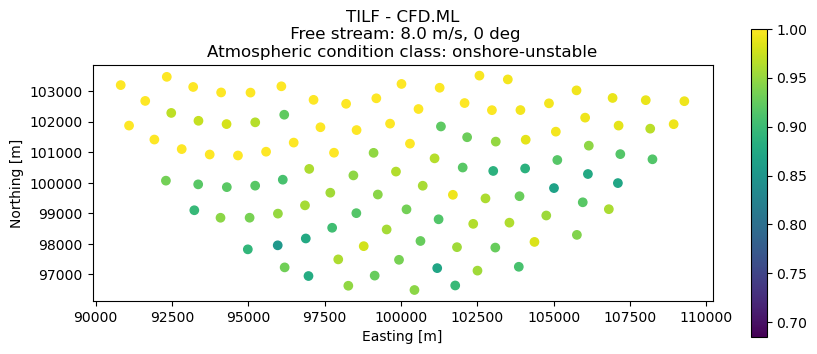

In [ ]:
# wind speed turbine interaction loss factor plotting accross array
wind_direction_index = int(wind_direction/ (360.0 / NUMBER_OF_DIRECTION_STEPS))
wind_speed_index = int(wind_speed)

waked_windspeed_cfdml = pd.DataFrame(results['windFarmAepOutputs'][0]['turbineFlowAndPerformanceMatricesWithMastBinning'])
waked_windspeed_cfdml.set_index('turbineName',drop=True, inplace=True)
for atmos_class in atmos_classes_for_direction:
    waked_windspeed_cfdml['atmosphericConditionAwareWakedWindSpeed_m_per_s{}'.format(atmos_class)] = waked_windspeed_cfdml['atmosphericConditionAwareWakedWindSpeed_m_per_s'].map(lambda x: x[atmos_class][wind_direction_index][wind_speed_index])

# Plot
waked_windspeed_cfdml['northing'] = per_turbine_results['northing']
waked_windspeed_cfdml['easting'] = per_turbine_results['easting']

vmin = 1.0
for atmos_class in atmos_classes_for_direction:
    waked_windspeed_cfdml['TILF {}'.format(atmos_class)] = waked_windspeed_cfdml['atmosphericConditionAwareWakedWindSpeed_m_per_s{}'.format(atmos_class)] / wind_speed
    bl_vmin = waked_windspeed_cfdml['TILF {}'.format(atmos_class)].min()
    if bl_vmin < vmin:
        vmin = bl_vmin
for atmos_class in atmos_classes_for_direction:
    fig3, ax3 = plt.subplots(figsize=(10,4))
    im2 = ax3.scatter(waked_windspeed_cfdml['easting'], waked_windspeed_cfdml['northing'], c=waked_windspeed_cfdml['TILF {}'.format(atmos_class)], cmap='viridis', vmin=vmin, vmax=1.0)
    fig3.colorbar(im2)
    ax3.set_title(f"TILF - CFD.ML\n Free stream: {wind_speed} m/s, {wind_direction} deg\nAtmospheric condition class: {bl_class}")
    ax3.set_xlabel("Easting [m]")
    ax3.set_ylabel("Northing [m]")
    ax3.set_aspect('equal', adjustable='box')

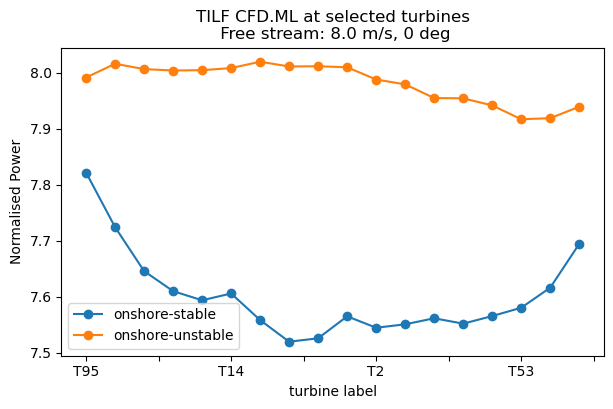

In [ ]:
# Plot wind speed pattern for user specified turbines
northern_edge = ['T95', 'T61', 'T48', 'T36', 'T24', 'T14', 'T10', 'T6', 'T3', 'T1', 'T2', 'T4', 'T9', 'T26', 'T33', 'T53', 'T74', 'T96']
#southern_edge = ['T95', 'T104', 'T99', 'T107', 'T102', 'T110', 'T97', 'T105', 'T100', 'T108', 'T103', 'T98', 'T106', 'T101', 'T109', 'T96']

fix, ax = plt.subplots(figsize=(7,4))
for atmos_class in atmos_classes_for_direction:
    (waked_windspeed_cfdml.loc[northern_edge]['atmosphericConditionAwareWakedWindSpeed_m_per_s{}'.format(atmos_class)]).plot(marker='o', ax=ax )
    handles, labels = ax.get_legend_handles_labels()
    ax.set_title(f'TILF CFD.ML at selected turbines\n Free stream: {wind_speed} m/s, {wind_direction} deg')
    ax.set_ylabel('Normalised Power')
    ax.set_xlabel('turbine label')
ax.legend(handles, atmos_classes_for_direction)
